<h1>3.2. Corriente oscura real: ruido y otros artefactos

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from astropy.nddata import CCDData
from astropy.visualization import hist

from convenience_functions import show_image

In [2]:
# Use custom style for larger fonts and figures
plt.style.use('guide.mplstyle')

# 3.2.1. Hacer una imagen para comprobar si hay píxeles calientes 
Medir la corriente oscura en una cámara requiere tomar imágenes con un tiempo de exposición bastante largo, idealmente lo suficientemente largo como para que los recuentos esperados debido a la corriente oscura sean mayores que el ruido esperado en la imagen. Si ese no es el caso, las imágenes oscuras medirán el ruido, no la corriente oscura, como vimos en la sección anterior .

Hay dos formas de asegurarse de que está midiendo corriente oscura:

Tome algunos marcos oscuros de larga exposición. El tiempo de exposición debe ser lo suficientemente largo para que los conteos oscuros esperados sean al menos tan grandes como el ruido esperado en una sola imagen.

Tome varias de estas imágenes y combínelas para reducir el ruido en el resultado. El ruido en la imagen combinada es proporcional a, donde  es el número de imágenes que se combinan.

# 3.2.1.1. ¿Qué pasa si eso no es posible? ¶
Haz tu mejor esfuerzo. Las imágenes oscuras de la cámara de gran formato se tomaron como parte de una carrera científica en la que había un tiempo limitado para tomar imágenes oscuras. Lo más importante a tener en cuenta es el límite inferior de la corriente oscura que puede medir, dado el ruido de lectura y el tiempo de exposición.

Los oscuros en el Caso 2 se tomaron con una cámara nueva que aún no estaba montada en el telescopio como parte de la puesta en marcha de la cámara. ¡Eso hizo que tomar más de cinco horas de marcos oscuros fuera más factible!

3.2.2. Caso 1: Cámara de formato grande (LFC) enfriada criogénicamente en Palomar 
Las imágenes de esta sección son del chip 0 del LFC en el telescopio Palomar de 200 pulgadas. La información técnica sobre la cámara está aquí . La información técnica no dice nada sobre la esperada corriente oscura de esta cámara. La expectativa para las cámaras enfriadas por nitrógeno líquido es que su corriente oscura sea esencialmente cero.

Lo que veremos con esta cámara es que

no todos los píxeles tienen una corriente oscura insignificante, y

no todos los conteos en una imagen oscura son de corriente oscura.



In [4]:
calibrated_images = Path('.')
combined_dark_lfc = CCDData.read(calibrated_images / 'combined_dark_300.000.fits.bz2')

# 3.2.2.1. Estimación del tiempo de exposición y número de fotogramas para medir la corriente oscura 
Desafortunadamente, la información técnica de esta cámara no incluye ninguna información sobre la corriente oscura esperada. Para cámaras enfriadas termoeléctricamente, la corriente oscura no es más de 0.1/seg/pixel, y para cámaras más nuevas es más como 0.01/seg/píxel. Asumiremos la corriente oscura más pequeña aquí.

El ruido de lectura de esta cámara es 11/píxel, por lo que el tiempo de exposición necesario para alcanzar el caso en el que los recuentos oscuros son iguales al ruido de lectura es

 
Incluso eso nos deja con una imagen dominada por el ruido de lectura en lugar de la corriente oscura. Combinar 100 de esas imágenes reduciría el ruido de lectura en un factor de 10, lo que sería ideal para medir con precisión la corriente oscura en cada píxel. Desafortunadamente, tomar más de 30 horas de imágenes oscuras no es factible.

En cambio, trabajaremos con lo que tenemos para esta cámara: tres imágenes oscuras, cada una de 300 segundos. Esto coloca un límite inferior en la corriente oscura que podemos medir (solo podremos medir la corriente oscura para píxeles bastante "calientes"), pero al menos nos da una idea de las propiedades oscuras de la cámara.

Otra forma de expresar esto es mucho más positiva: para la mayoría de los píxeles de la imagen, la corriente oscura simplemente no importa porque está completamente inundada por el ruido de lectura.

Primero, leemos en la imagen.

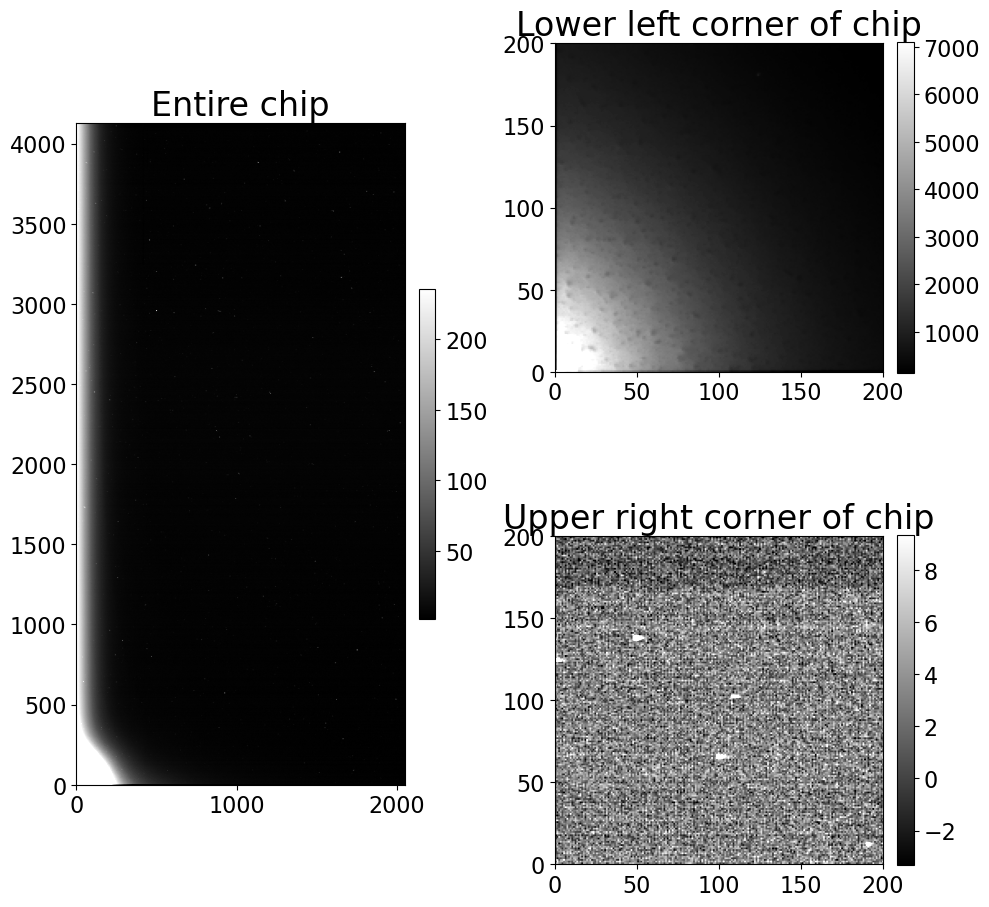

In [5]:
fig = plt.figure(figsize=(10, 10))
whole_im_ax = plt.subplot(121)
glow_ax = plt.subplot(222)
dark_ax = plt.subplot(224)

show_image(combined_dark_lfc, cmap='gray', ax=whole_im_ax, fig=fig)
whole_im_ax.set_title('Entire chip')

show_image(combined_dark_lfc[:200, :200], cmap='gray', ax=glow_ax, fig=fig)
glow_ax.set_title('Lower left corner of chip')

show_image(combined_dark_lfc[-200:, -200:], cmap='gray', ax=dark_ax, fig=fig)
dark_ax.set_title('Upper right corner of chip')

plt.tight_layout()

# 3.2.2.3. Corriente oscura en este CCD 
El siguiente histograma muestra la corriente oscura a lo largo del eje horizontal y el número de píxeles en el CCD con esa corriente oscura a lo largo del eje vertical. Dado que hay un brillo obvio del sensor en la oscuridad, se muestran tres distribuciones:

El sensor completo, que a primera vista tiene algunos píxeles con corriente oscura de hasta 10/segundo.

La parte del sensor que excluye el brillo del sensor, en la que la corriente oscura es, como se esperaba, baja, aunque hay una pequeña fracción de "píxeles calientes" con corriente oscura alrededor de 1/segundo.

La región de brillo del sensor. Esa región es evidente en el grupo de píxeles con una corriente oscura equivalente de 0,5/seg y superior.

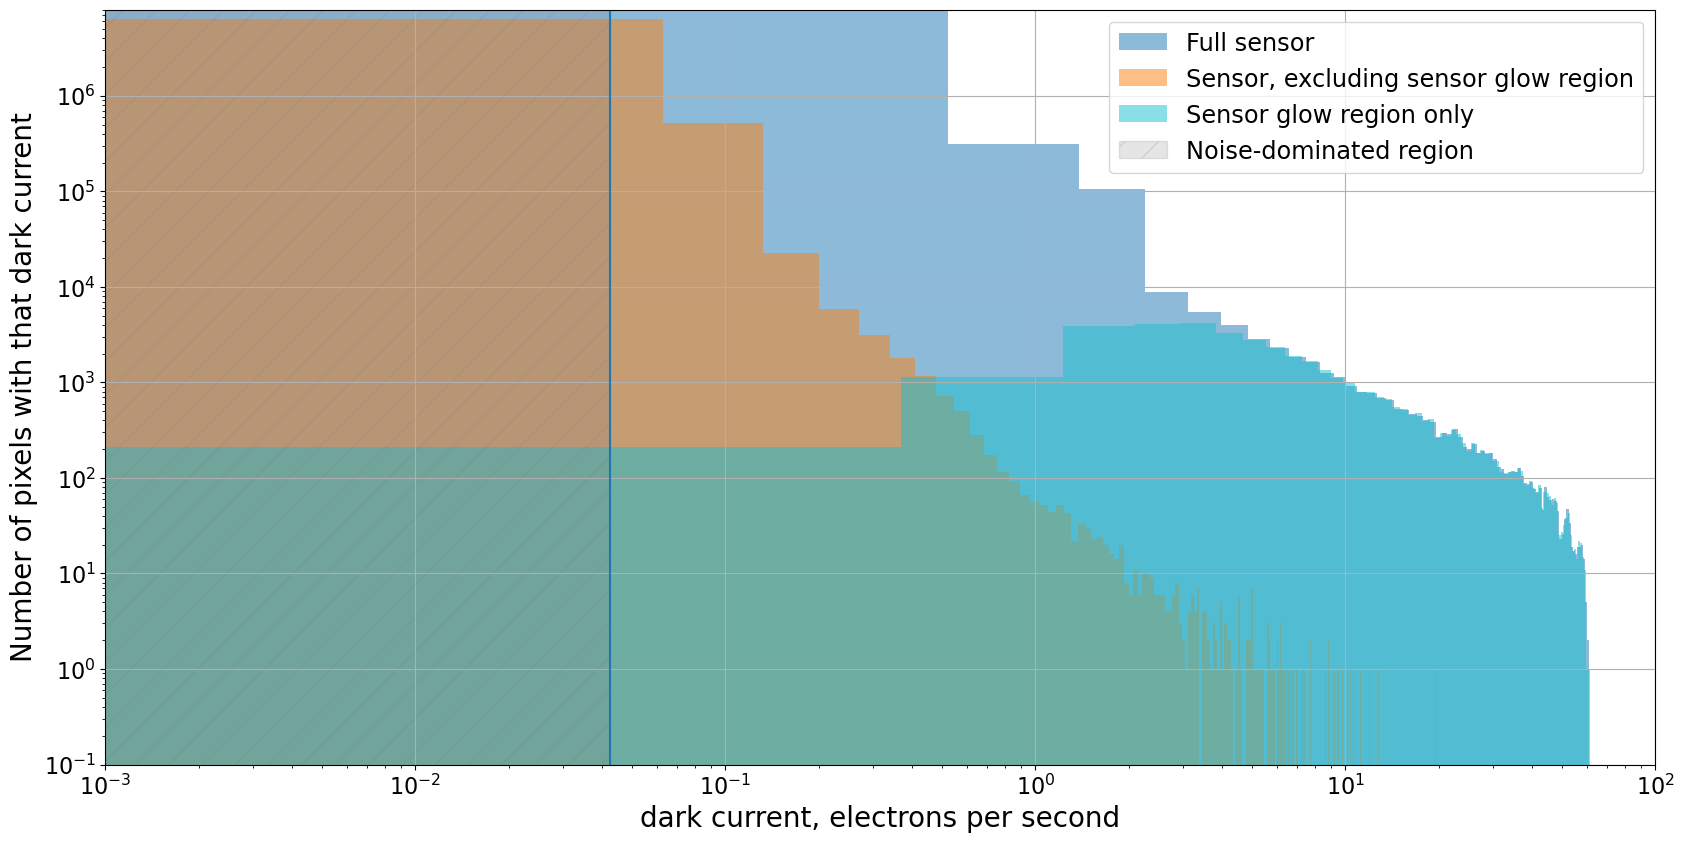

In [9]:
gain = 2.0
exposure_time = 300
dark_current_ln2 = gain * combined_dark_lfc.data / exposure_time

fig = plt.figure(figsize=(20, 10))
hist(dark_current_ln2.flatten(), bins=500, density=False, alpha=0.5, color='C0',
     label='Full sensor');
hist(dark_current_ln2[200:, 200:].flatten(), bins=500, density=False, alpha=0.5, color='C1',
     label='Sensor, excluding sensor glow region')
hist(dark_current_ln2[:200, :200].flatten(), bins=500, density=False, alpha=0.5, color='C9',
     label='Sensor glow region only');
#plt.semilogy()
plt.loglog()

plt.grid()
noise_limit = 2 * 11/exposure_time/np.sqrt(3)
plt.vlines(2 * 11/exposure_time/np.sqrt(3), 0.1, 8e6)
plt.ylim(0.1, 8e6)
plt.xlim(1e-3, 1e2)
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
noisy_region = plt.Rectangle((x_min, y_min), noise_limit - x_min, y_max - y_min, label='Noise-dominated region',
                             color='gray', alpha=0.2, hatch='/')
ax = plt.gca()
ax.add_patch(noisy_region)
plt.legend()
plt.xlabel('dark current, electrons per second')
plt.ylabel('Number of pixels with that dark current');

# .2.3. Caso 2: Cámara con refrigeración termoeléctrica 
# 3.2.3.1. Tomando una imagen para medir la corriente oscura 
La imagen de abajo es una combinación de 20 cuadros oscuros, cada uno con una exposición de 1000 segundos. Ese tiempo de exposición se eligió para que el número esperado de electrones oscuros fuera al menos un poco mayor que el ruido de lectura esperado en una combinación de 20 imágenes. Como vimos en el cuaderno anterior, a menos que ese sea el caso, los marcos oscuros medirán el ruido de lectura en lugar de la corriente oscura.

Esta cámara tiene una corriente oscura de/seg/píxel y ruido de lectura de aproximadamente /leer/píxel/, por lo que el tiempo de exposición en el que la corriente oscura es tan grande como el ruido de lectura es

 
Al combinar 20 de las imágenes, el ruido esperado en la combinación se reduce en un factor dea/píxel. Esto nos coloca en el límite de "ruido de lectura bajo" en el cuaderno anterior sobre la corriente oscura ideal.

Medir la corriente oscura una vez que tenga las imágenes es relativamente directo: reste el sesgo, multiplique el resultado por la ganancia y luego divida por el tiempo de exposición para obtener la corriente oscura en/píxel/seg.

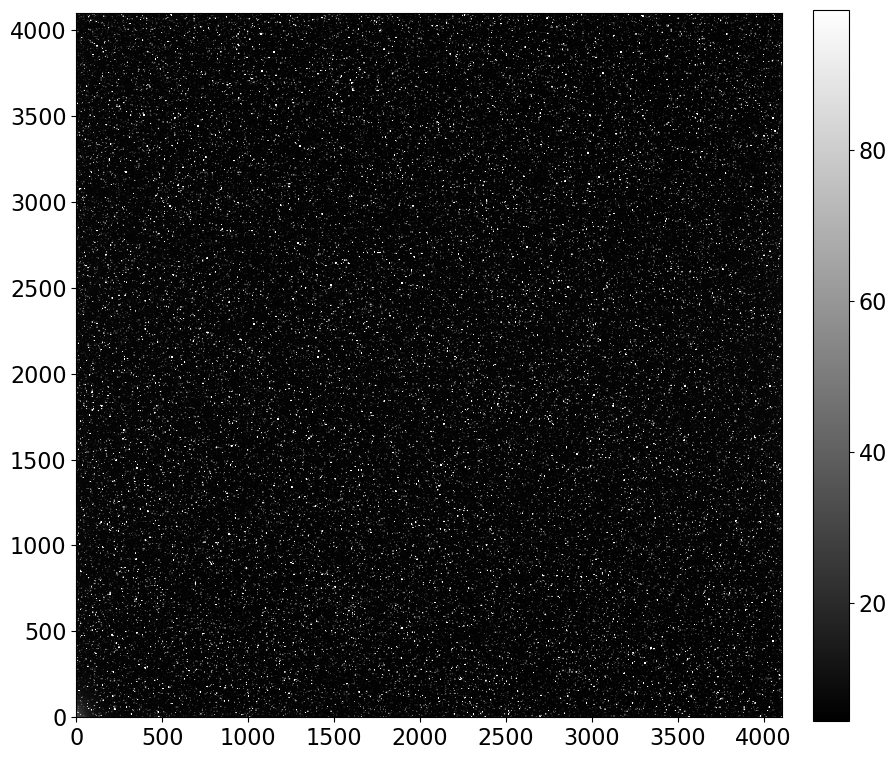

In [13]:
dark_1000 = CCDData.read('combined_dark_exposure_1000.0.fit.bz2')
show_image(dark_1000, cmap='gray')

# 3.2.3.2. Calcular la corriente oscura para cada píxel ¶
Recuerde que la corriente oscuraes dado por

dondees el número de electrones oscuros en las imágenes. Eso está relacionado con las cuentas oscuras,, los valores de imagen mostrados en la imagen de arriba, por la ganancia de la cámara,, de modo que

Esta cámara en particular tiene una ganancia de/ADU.

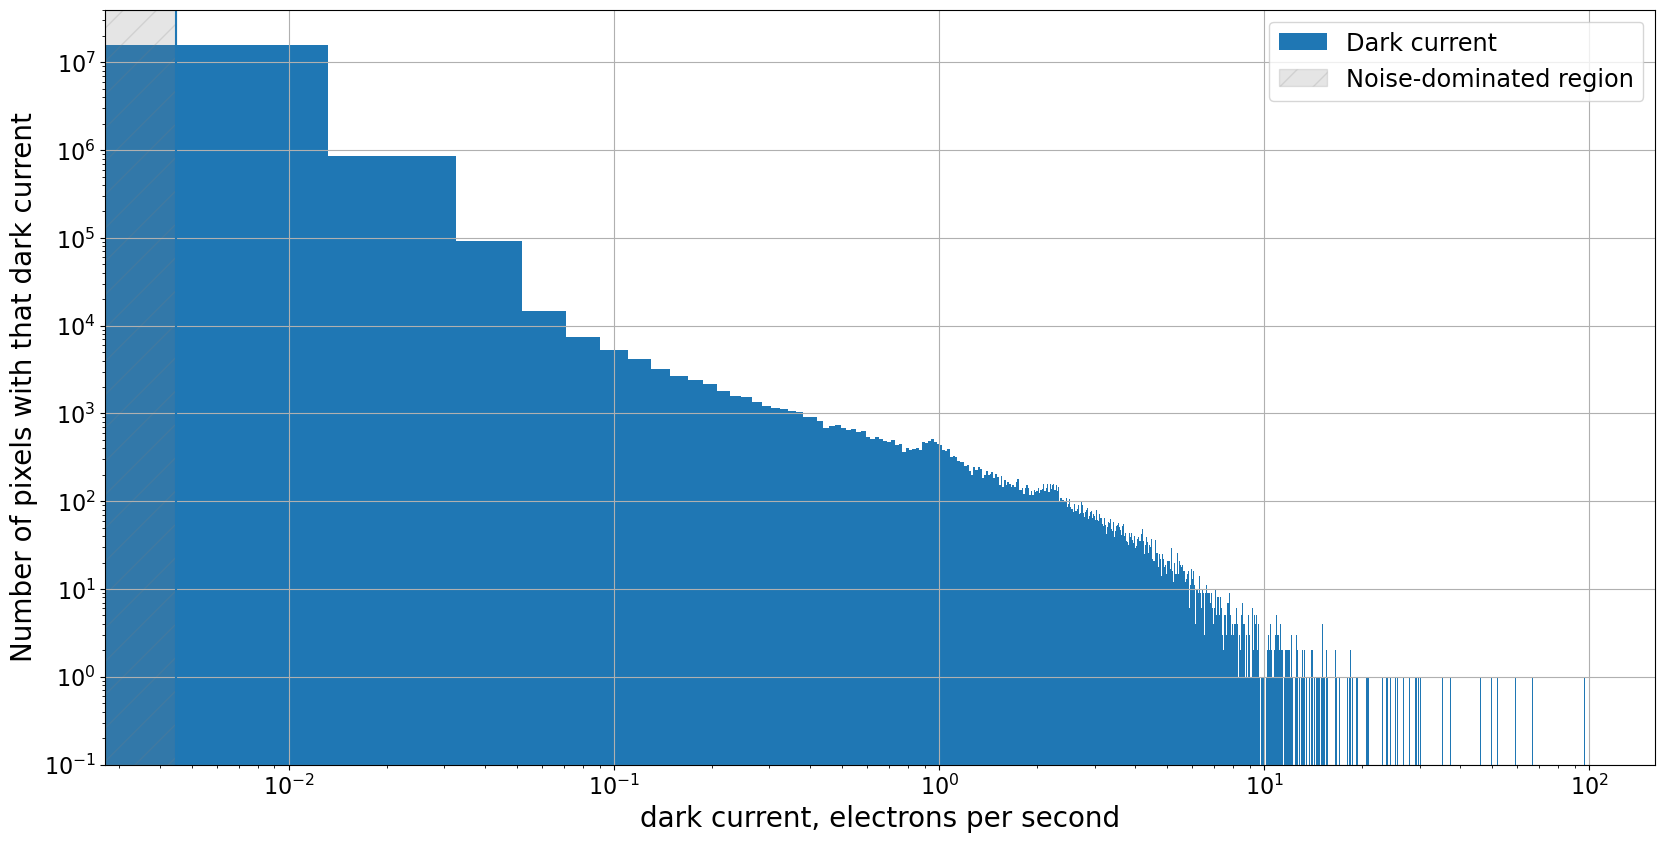

In [14]:
gain = 1.5
read_noise = 10.0
exposure_time = 1000

dark_current = gain * dark_1000.data / exposure_time

noisy_region = 2 * read_noise / exposure_time / np.sqrt(20)

plt.figure(figsize=(20, 10))
hist(dark_current.flatten(), bins=5000, density=False, label='Dark current');

plt.ylim(0.1, 4e7)
plt.vlines(noisy_region, *plt.ylim())

plt.loglog()
plt.grid()


x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
noisy_region = plt.Rectangle((x_min, y_min), noisy_region - x_min, y_max - y_min, label='Noise-dominated region',
                             color='gray', alpha=0.2, hatch='/')
ax = plt.gca()
ax.add_patch(noisy_region)

plt.legend()

plt.xlabel('dark current, electrons per second')
plt.ylabel('Number of pixels with that dark current');

# 3.2.3.3. Hay un gran rango en la corriente oscura 
Si bien la gran mayoría de los píxeles, como se esperaba, tienen una corriente oscura muy baja, es mucho mayor para otros píxeles. Estos píxeles, llamados píxeles calientes, pueden ocurrir incluso en cámaras enfriadas criogénicamente.

La gran mayoría de los píxeles de la imagen tienen una corriente oscura en torno al valor prometido por el fabricante, 0,01 /segundo; los más altos nominalmente tienen una corriente oscura de 98/segundo.

Sin embargo, existe un límite superior para la corriente oscura que se puede medir en una exposición particular porque el CCD se satura una vez que los conteos son lo suficientemente grandes. En otras palabras, existe un límite superior para el número de conteos que puede representar un CCD; para esta cámara el límite es, o cuenta Si convertimos eso en una corriente oscura para una exposición de 1000 segundos, es aproximadamente


                        dark current for saturated pixel = gainx(saturario Counts/exposure time)=1.5(e/count)(65563count/1000sec)=98(e/sec)
 
 
 
Para los píxeles más calientes de esta imagen, ese es el límite inferior de la corriente oscura para esos píxeles.

La corriente oscura tampoco está bien estimada para píxeles un poco por debajo del máximo porque los CCD dejan de responder linealmente una vez que pasan un valor de píxel que depende de la cámara. Para esta cámara, el límite de linealidad es de alrededor de 55 000 conteos, lo que corresponde a una corriente oscura de aproximadamente 82/segundo.

En principio, también puede verificar si los píxeles calientes tienen o no una corriente oscura constante que no cambia con el tiempo creando una cantidad de estos oscuros en diferentes tiempos de exposición y trazando la corriente oscura como una función del tiempo de exposición para los puntos calientes. píxeles Si la corriente oscura es constante, los recuentos oscuros se eliminarán correctamente cuando la oscuridad se reste de la imagen científica. Si la corriente oscura no es constante, el píxel debe excluirse del análisis.

La fracción de píxeles muy calientes, los que están por encima de 1 /seg, es relativamente pequeño, aproximadamente el 0,1% de los píxeles.

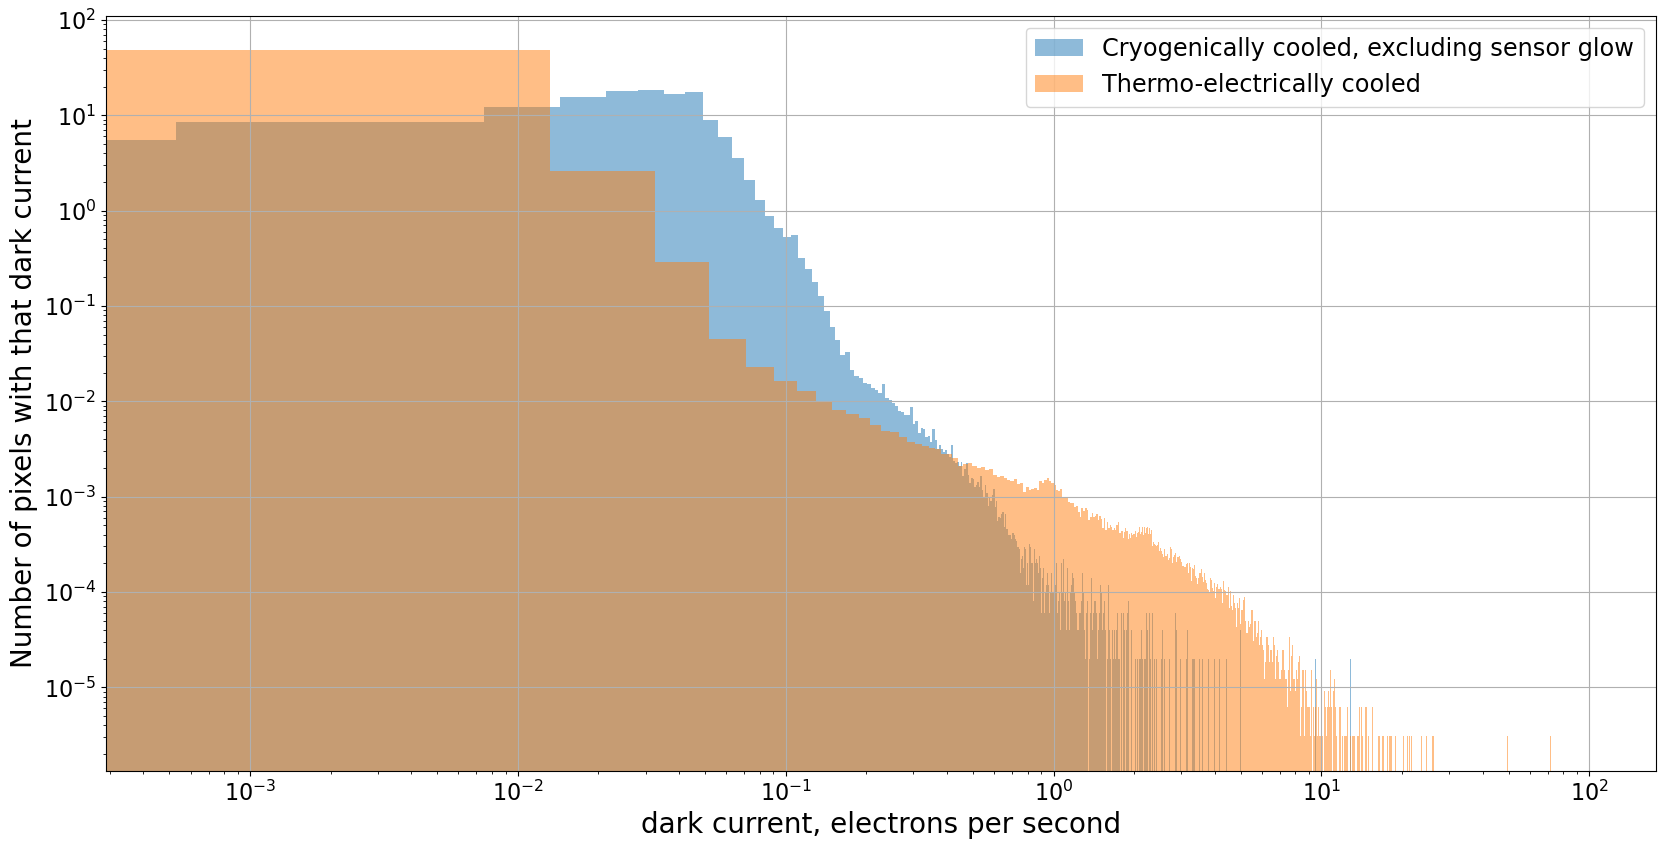

In [15]:
plt.figure(figsize=(20, 10))
hist(dark_current_ln2[200:, 200:].flatten(), bins=5000, density=True, alpha=0.5, label='Cryogenically cooled, excluding sensor glow');
hist(dark_current.flatten(), bins=5000, density=True, alpha=0.5, label='Thermo-electrically cooled');
plt.grid()
plt.loglog()
plt.xlabel('dark current, electrons per second')
plt.ylabel('Number of pixels with that dark current');
plt.legend();

# 3.2.4. Cómo manejar los píxeles calientes 
Hay algunas maneras en que podría manejar esto, que se pueden usar en combinación entre sí:

Marque todos los píxeles por encima de cierto umbral como malos y cree una máscara para realizar un seguimiento de estos píxeles malos.

Marque solo los píxeles de corriente oscura realmente altos como malos y enmascárelos; para el resto, reste la corriente oscura como de costumbre.

Tome siempre imágenes oscuras con tiempos de exposición que coincidan con sus marcos planos y claros y reste la corriente oscura como de costumbre.

Tome un conjunto de oscuros con una exposición igual al tiempo de exposición más largo en sus imágenes planas y claras y escale la corriente oscura hacia abajo para que coincida con sus otros tiempos de exposición.

# 3.2.5. Una cosa que NO se debe hacer 
No tome fotogramas oscuros cortos y amplíelos a tiempos de exposición más largos. Las cámaras modernas, incluso las enfriadas termoeléctricamente, tienen una corriente oscura muy baja. Si sus marcos oscuros tienen un tiempo de exposición bajo, la mayoría de los píxeles miden el ruido de lectura, no la corriente oscura. Si cambia la escala de esas imágenes a un tiempo de exposición más largo, amplificará inapropiadamente ese ruido. Idealmente, los conteos oscuros esperados (o electrones oscuros) en sus marcos oscuros deben ser al menos algunas veces más grandes que el ruido de lectura esperado en los marcos que combina para hacer una referencia oscura.

# 3.2.6. Resumen 
Un marco oscuro solo mide la corriente oscura si los conteos oscuros esperados exceden el ruido de lectura de la cámara por un factor de unos pocos.

Tome varios cuadros oscuros y combínelos para reducir el nivel de ruido en la imagen combinada tanto como sea posible.

La mayoría de los píxeles de un CCD tienen una corriente oscura muy baja.

Una consecuencia de 1 y 3 es que casi nunca debe escalar sus cuadros oscuros a un tiempo de exposición más largo porque amplificará el ruido en lugar de eliminar la corriente oscura, incluso si ha combinado varias imágenes como en 2.

Identifique los píxeles calientes y enmascárelos o trátelos de otra manera.